## Extract jokes text

In [1]:
import pandas as pd
import os
import re
from bs4 import BeautifulSoup

jokes_dir = "../data/jokes"
jokes_data = []
pattern = re.compile(r"\d+")

for file in os.listdir(jokes_dir):
    if not file.endswith(".html"):
        continue

    joke_number = int(pattern.findall(file)[0])

    with open(os.path.join(jokes_dir, file), "r") as f:
        content = f.read()
        soup = BeautifulSoup(content, "html.parser")
        body_text = soup.body.get_text().strip()
        jokes_data.append((joke_number, body_text))

jokes_df = pd.DataFrame(jokes_data, columns=["joke_number", "joke_text"])
jokes_df.sort_values(by="joke_number", inplace=True)
jokes_df.drop("joke_number", axis=1,inplace=True)
jokes_df.reset_index(drop=True,inplace=True)

print(jokes_df.head(10))


                                           joke_text
0  A man visits the doctor. The doctor says "I ha...
1  This couple had an excellent relationship goin...
2  Q. What's 200 feet long and has 4 teeth? \n\nA...
3  Q. What's the difference between a man and a t...
4  Q.\tWhat's O. J. Simpson's Internet address? \...
5  Bill & Hillary are on a trip back to Arkansas....
6  How many feminists does it take to screw in a ...
7  Q. Did you hear about the dyslexic devil worsh...
8  A country guy goes into a city bar that has a ...
9  Two cannibals are eating a clown, one turns to...


## Extract the ratings

In [3]:
ratings_path = "../data/jester-data-1.xls"
ratings_df = pd.read_excel(ratings_path, header=None)

ratings_df.drop(ratings_df.columns[0], inplace=True, axis=1)

new_column_index = range(len(ratings_df.columns))
ratings_df.columns = new_column_index

ratings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,...,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,...,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,...,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [4]:
import numpy as np

# Change 99 to NaN (99 represeents lack of value)
ratings_df.replace(99, np.nan, inplace=True)

## Generate embeddings

In [5]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("bert-base-cased")

/home/tomek/repos/jester-jokes-neural-network/env/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
No sentence-transformers model found with name bert-base-cased. Creating a new one with mean pooling.
/home/tomek/repos/jester-jokes-neural-network/env/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
jokes_df["encoded_joke"] = jokes_df["joke_text"].apply(model.encode)
jokes_df.head()

,joke_text,encoded_joke
0,"A man visits the doctor. The doctor says ""I ha...","[0.22689942, 0.080852464, 0.19379224, 0.222370..."
1,This couple had an excellent relationship goin...,"[0.08381987, 0.15879399, -0.18693112, 0.112136..."
2,Q. What's 200 feet long and has 4 teeth? \n\nA...,"[0.02886742, 0.04255907, -0.073530644, 0.08311..."
3,Q. What's the difference between a man and a t...,"[0.35024598, -0.16287658, 0.021109877, -0.0664..."
4,Q.\tWhat's O. J. Simpson's Internet address? \...,"[0.21226716, 0.17400345, 0.33756003, 0.1001134..."


## Prepare the data for training

In [8]:
ratings_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,...,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN,...,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,NaN,1.84,...,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24978,0.44,7.43,9.08,2.33,3.20,6.75,-8.79,-0.53,-8.74,7.23,...,8.83,-1.21,9.22,-6.70,8.45,9.03,6.55,8.69,8.79,7.43
24979,9.13,-8.16,8.59,9.08,0.87,-8.93,-3.50,5.78,-8.11,4.90,...,-1.17,-5.73,-1.46,0.24,9.22,-8.20,-7.23,-8.59,9.13,8.45
24980,NaN,NaN,NaN,NaN,-7.77,NaN,6.70,-6.75,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24981,NaN,NaN,NaN,NaN,-9.71,NaN,4.56,-8.30,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
jokes_df["median_rating"] = ratings_df.median()
jokes_df["mean_rating"] = ratings_df.mean()

In [10]:
from sklearn.model_selection import train_test_split
X = np.vstack(jokes_df["encoded_joke"].to_numpy())
y_median = jokes_df["median_rating"]
y_mean = jokes_df["mean_rating"]

X_train_median, X_val_median, y_train_median, y_val_median = train_test_split(X, y_median, test_size=0.2, random_state=42)
X_train_mean, X_val_mean, y_train_mean, y_val_mean = train_test_split(X, y_mean, test_size=0.2, random_state=42)

## Functions for training and plotting

In [11]:
from sklearn.metrics import mean_squared_error

def train_network(model, X_train, y_train, X_val, y_val, epochs, print_progress=False):
    train_loss = []
    val_loss = []

    for epoch in range(epochs):
        model.partial_fit(X_train, y_train)
        
        train_pred = model.predict(X_train)
        train_loss.append(mean_squared_error(y_train, train_pred))
        
        val_pred = model.predict(X_val)
        val_loss.append(mean_squared_error(y_val, val_pred))
    
        if(print_progress):
            print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss[-1]}, Validation Loss: {val_loss[-1]}')

    return (train_loss, val_loss)

In [12]:
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor

def plot_loss(train_loss, val_loss, title="Loss over epochs"):
    epochs = len(train_loss)
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.plot(range(1, epochs + 1), train_loss, label='Training Loss') 
    plt.plot(range(1, epochs + 1), val_loss, label='Validation Loss') 
    
    min_train_loss = min(train_loss)
    min_val_loss = min(val_loss)
    max_train_loss = max(train_loss)
    max_val_loss = max(val_loss)
    
    plt.scatter(train_loss.index(min_train_loss) + 1, min_train_loss, color='red', marker='x', label=f'Min Train Loss: {min_train_loss:.2f}')
    plt.scatter(val_loss.index(min_val_loss) + 1, min_val_loss, color='red', marker='x', label=f'Min Val Loss: {min_val_loss:.2f}')
    plt.scatter(train_loss.index(max_train_loss) + 1, max_train_loss, color='green', marker='x', label=f'Max Train Loss: {max_train_loss:.2f}')
    plt.scatter(val_loss.index(max_val_loss) + 1, max_val_loss, color='green', marker='x', label=f'Max Val Loss: {max_val_loss:.2f}')
    
    plt.xlabel('epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()



## MLP with default parameters

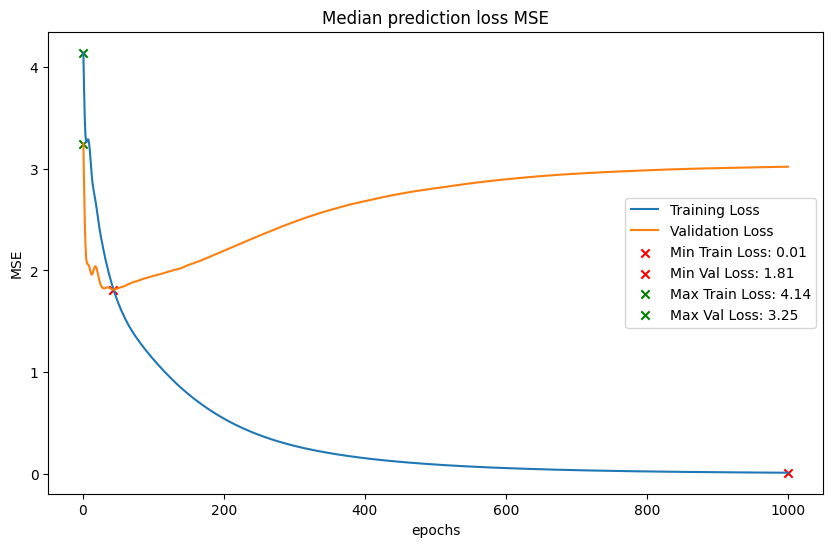

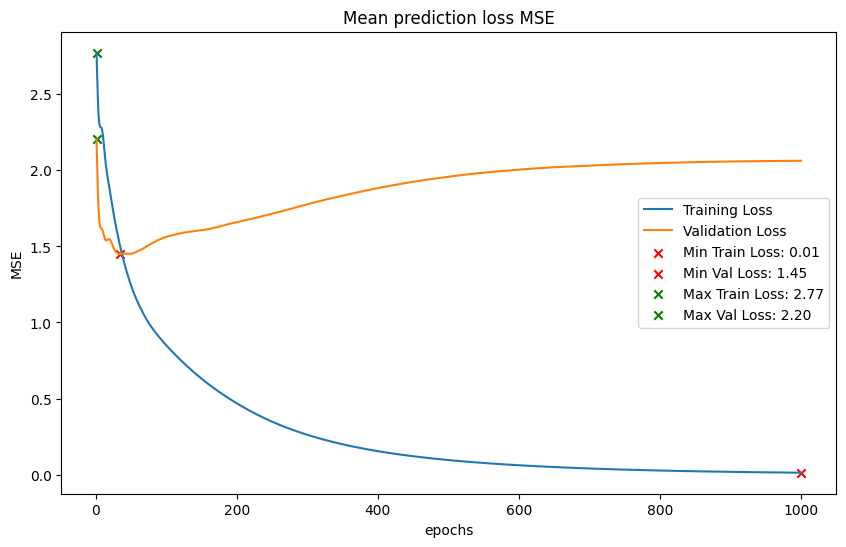

In [13]:
mlp = MLPRegressor(solver="sgd", alpha=0.0, learning_rate="constant")
median_loss = train_network(mlp, X_train_median, y_train_median, X_val_median, y_val_median, 1000)

mlp = MLPRegressor(solver="sgd", alpha=0.0, learning_rate="constant")
mean_loss = train_network(mlp, X_train_mean, y_train_mean, X_val_mean, y_val_mean, 1000)

plot_loss(median_loss[0], median_loss[1], "Median prediction loss MSE")
plot_loss(mean_loss[0], mean_loss[1], "Mean prediction loss MSE")

## Influence of learning rate

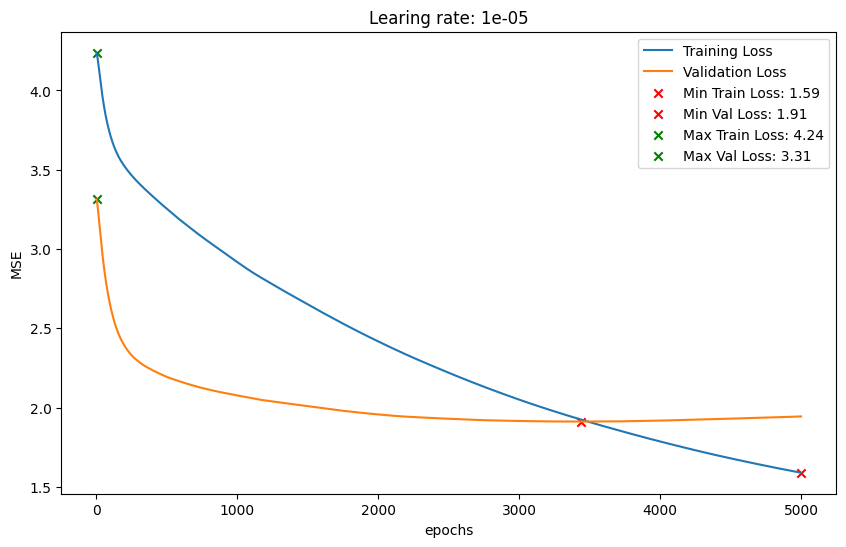

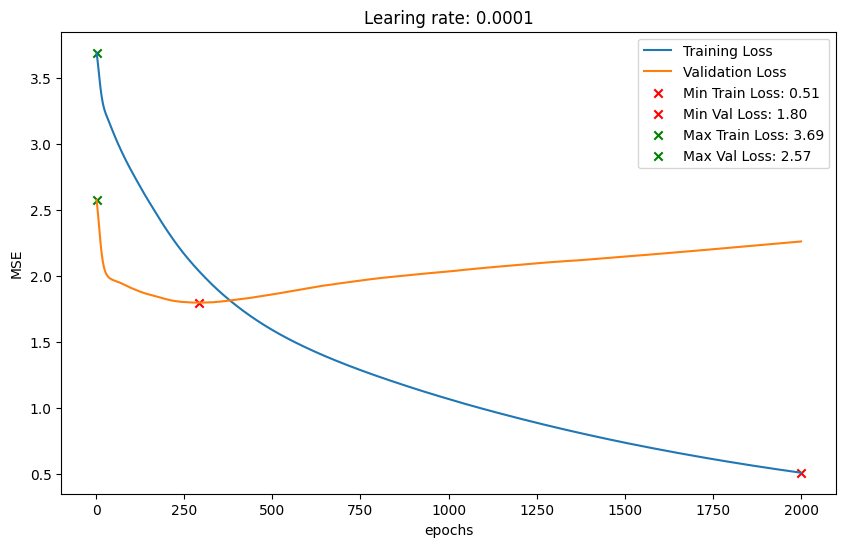

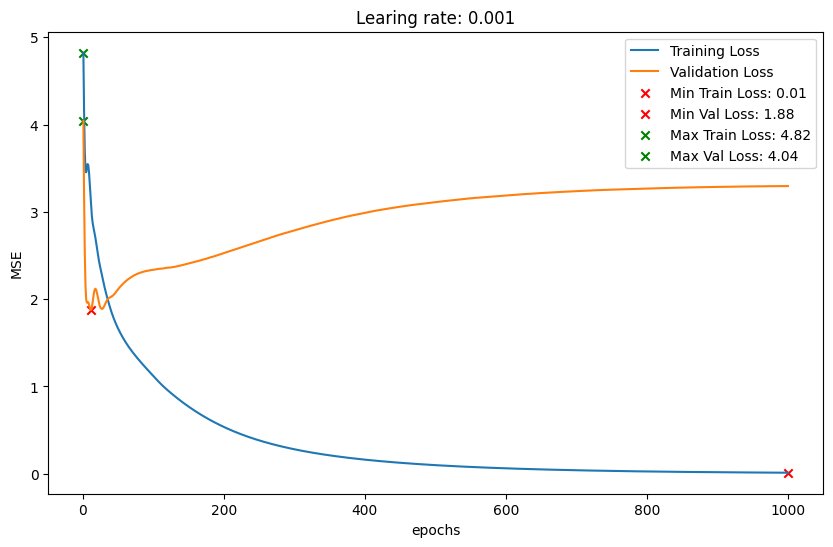

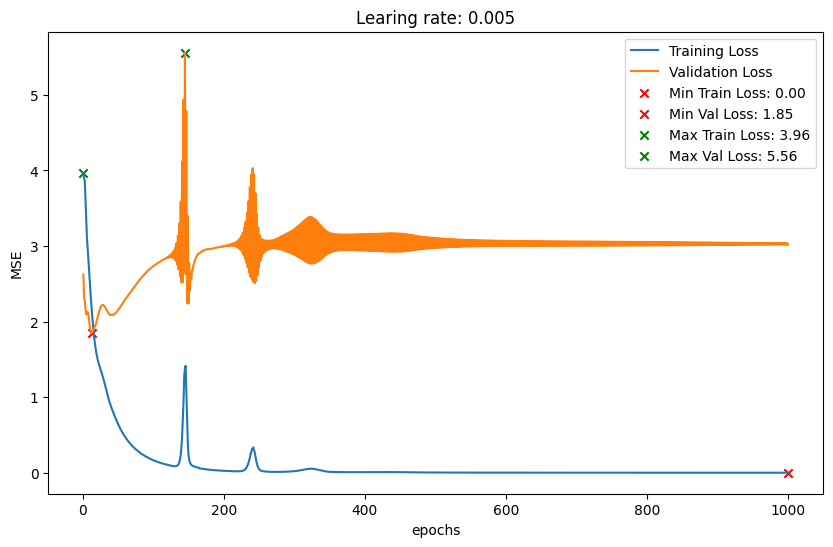

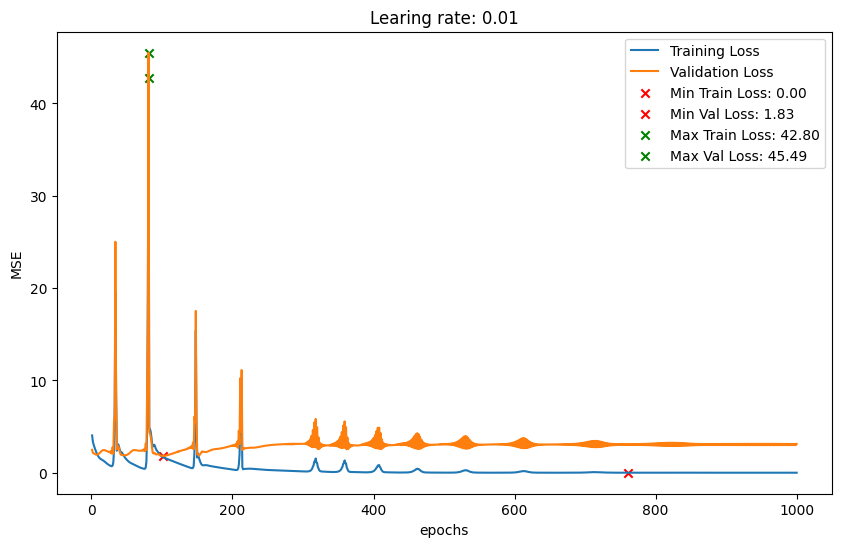

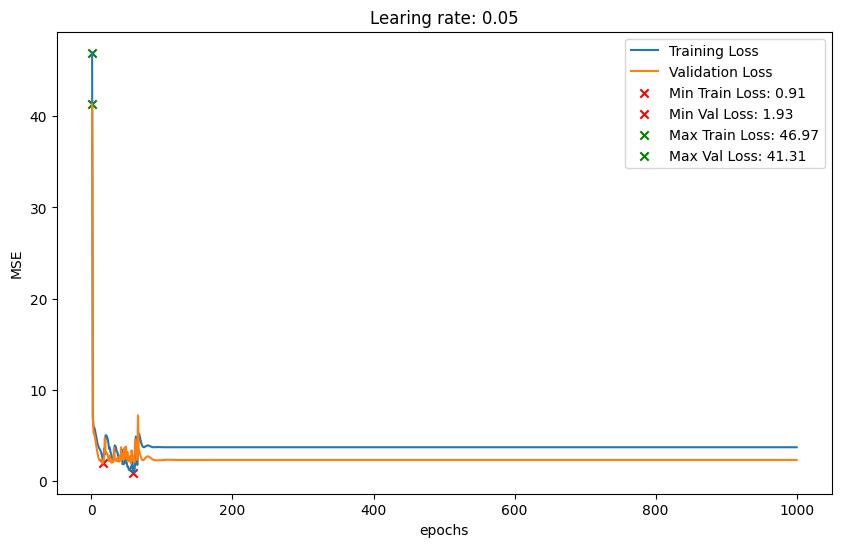

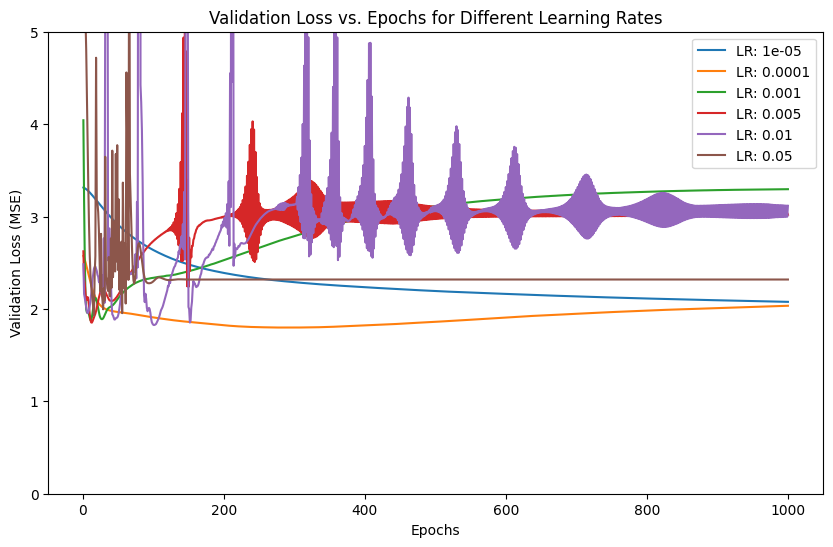

In [14]:
learning_rates = [0.00001, 0.0001, 0.001, 0.005, 0.01, 0.05]
epoch_counts = [5000, 2000, 1000, 1000, 1000, 1000]

losses = []
for i in range(len(learning_rates)):
    mlp = MLPRegressor(solver="sgd", alpha=0.0, learning_rate="constant", learning_rate_init=learning_rates[i])
    loss = train_network(mlp, X_train_median, y_train_median, X_val_median, y_val_median, epoch_counts[i])
    losses.append((f"{learning_rates[i]}", loss[1]))
    plot_loss(loss[0], loss[1], f"Learing rate: {learning_rates[i]}")



plt.figure(figsize=(10, 6))
    
for lr, val_loss in losses:
    epochs = range(1, min(len(val_loss), 1000) + 1)
    truncated_val_loss = val_loss[:1000]
    plt.plot(epochs, truncated_val_loss, label=f'LR: {lr}')

plt.xlabel('Epochs')
plt.ylim(0,5)
plt.ylabel('Validation Loss (MSE)')
plt.title('Validation Loss vs. Epochs for Different Learning Rates')
plt.legend()
plt.show()


## Influence of hidden_layer_sizes

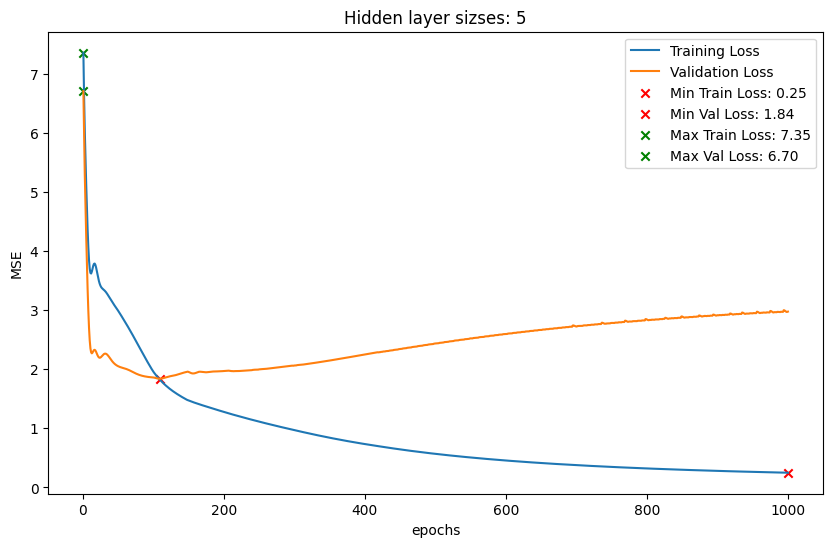

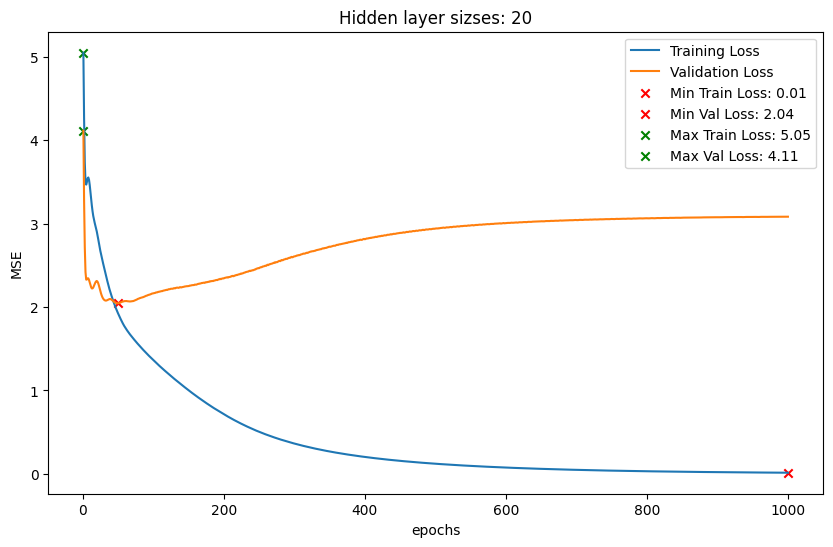

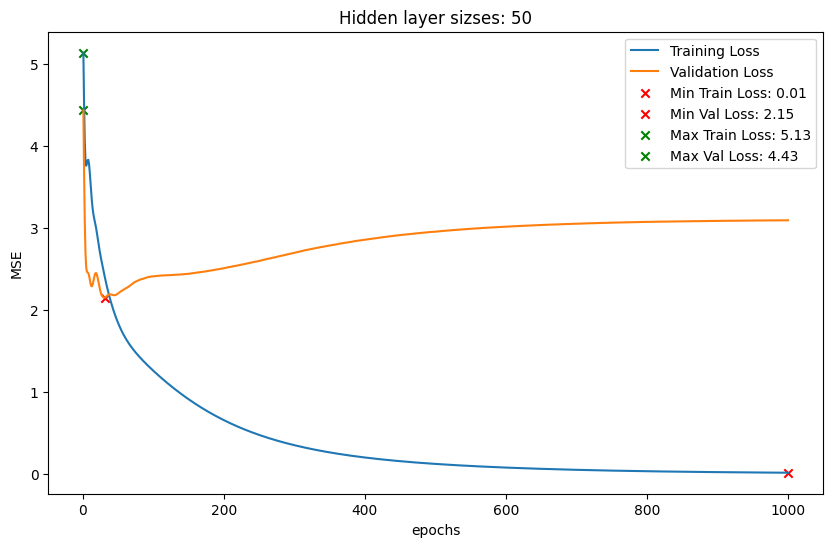

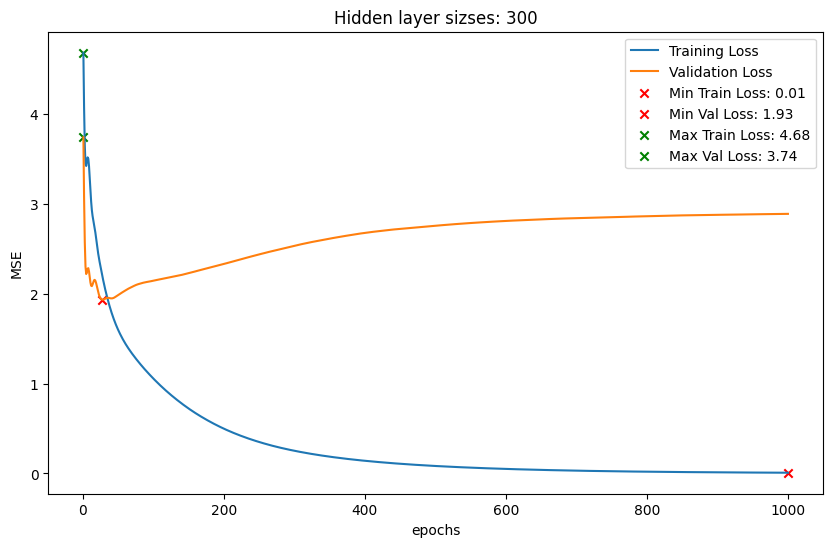

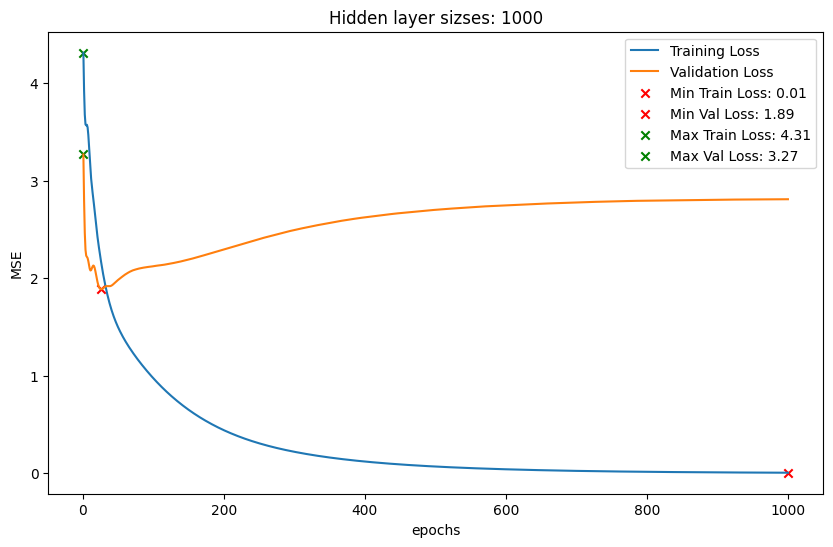

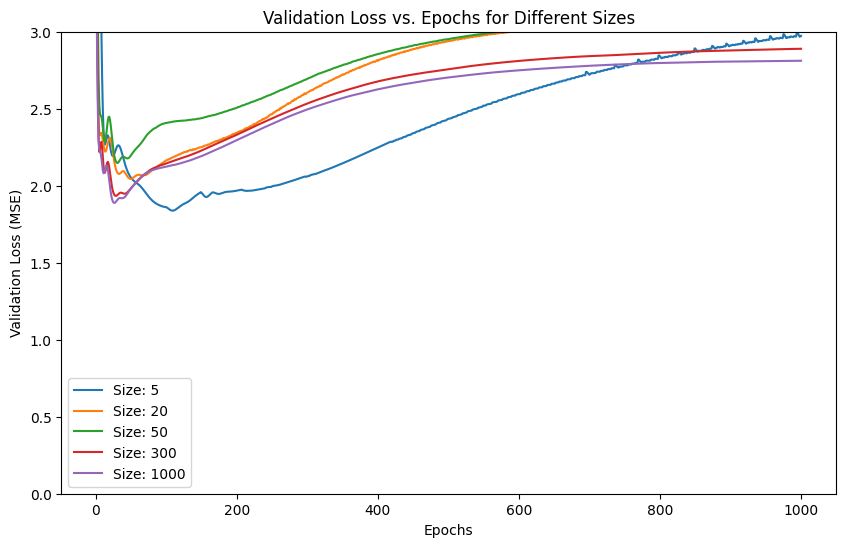

In [15]:
layer_sizes = [5, 20, 50, 300,1000]
losses = []

for size in layer_sizes:
    mlp = MLPRegressor(solver="sgd", alpha=0.0, learning_rate="constant", hidden_layer_sizes=(size,))
    loss = train_network(mlp, X_train_median, y_train_median, X_val_median, y_val_median, 1000)
    losses.append((f"{size}", loss[1]))
    plot_loss(loss[0], loss[1], f"Hidden layer sizses: {size}")


plt.figure(figsize=(10, 6))
    
for size, val_loss in losses:
    epochs = range(1, min(len(val_loss), 1000) + 1)
    truncated_val_loss = val_loss[:1000]
    plt.plot(epochs, truncated_val_loss, label=f'Size: {size}')

plt.xlabel('Epochs')
plt.ylabel('Validation Loss (MSE)')
plt.title('Validation Loss vs. Epochs for Different Sizes')
plt.ylim(0,3)
plt.legend()
plt.show()

## Own jokes

In [16]:
jokes = [
    "What's the difference between a teacher and a train? A teacher says 'no chewing' and a train says 'choo-choo'!",
    "What do you call a lion tamer who sticks his right arm down a lion's throat? Lefty!",
    "What happens if you don't pay your exorcist? You get repossessed!",
    "What kind of quiz do you give to a criminal? A con test!",
    "Why aren't elephants allowed on beaches? They can't keep their trunks up!",
    "What do you get when you cross a baseball player with a boy scout? Someone who likes to pitch tents!",
]

model = SentenceTransformer("bert-base-cased")
encoded_jokes = model.encode(jokes)


No sentence-transformers model found with name bert-base-cased. Creating a new one with mean pooling.
/home/tomek/repos/jester-jokes-neural-network/env/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


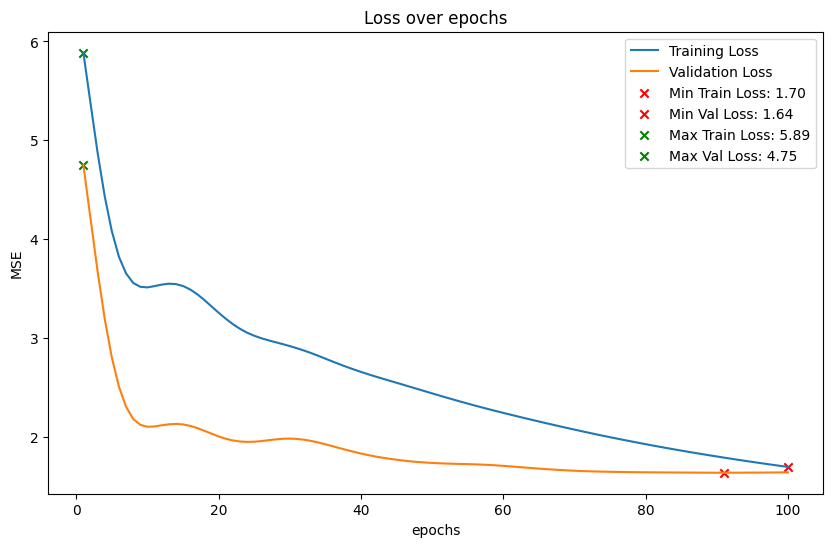

What's the difference between a teacher and a train? A teacher says 'no chewing' and a train says 'choo-choo'! -> 0.3281881809234619
What do you call a lion tamer who sticks his right arm down a lion's throat? Lefty! -> 0.14381563663482666
What happens if you don't pay your exorcist? You get repossessed! -> 0.30516722798347473
What kind of quiz do you give to a criminal? A con test! -> -0.43229153752326965
Why aren't elephants allowed on beaches? They can't keep their trunks up! -> 0.03899265080690384
What do you get when you cross a baseball player with a boy scout? Someone who likes to pitch tents! -> 0.1345924437046051


In [33]:
X_custom  = np.vstack(encoded_jokes)
mlp = MLPRegressor(solver="sgd", alpha=0.0, learning_rate="constant", learning_rate_init=0.0005,
                  hidden_layer_sizes=(100,))

loss = train_network(mlp, X_train_median, y_train_median, X_val_median, y_val_median, 100)
plot_loss(loss[0], loss[1])

predictions = mlp.predict(X_custom)

for i in range(len(jokes)):
    print(f"{jokes[i]} -> {predictions[i]}")